# Intelligent Navigation System: Merging Search Algorithms and Reinforcement Learning for Efficient Pathfinding Under Dynamic Road Conditions in Real-World Scenarios – A Hybrid Approach


# Introduction

This work builds on a previous [Intelligent Navigation System](https://drive.google.com/file/d/15Rz-BwW9iCYD8gQVdM82XtySEEL7mkXL/view?usp=drive_link) that used search algorithms and reinforcement learning separately to find the shortest and most traffic-efficient path, respectively. It proposes a hybrid approach that combines search algorithms (for initial path planning) with RL for real-time optimization, allowing the system to adapt to dynamic road conditions such as traffic congestion, road closures, and other disruptions. 

The goal of the hybrid method is to address the limitations of using RL alone in dynamic environments, making pathfinding more efficient and practical. By integrating search algorithms for initial path planning, this approach will help to reduce the number of training episodes required for reinforcement learning to converge, significantly lowering computational costs, while continuously refining the route to ensure optimal navigation under real-world conditions. 

The algorithms utilized are:
1. Dijkstra uninformed search algorithm for initial path planning.
2. Q-learning reinforcement learning algorithm to learn the path, adapt to real-time, real-world dynamic road conditions, and reroute accordingly.

The project includes a comparative analysis of all the algorithms to identify the most optimal one based on all the given constraints.

To manage computational complexity, the map and its graph model will be limited to a 2100-meter radius around the center of Middlesbrough, England.

_**Disclaimer:** This system is developed for educational purposes only and may not reflect the accuracy or reliability required for real-world navigation._

_**N.B.** If you're running this locally, please refer to the requirements.txt file for a comprehensive list of Python libraries and packages utilized in this project, along with their respective versions._


In [1]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

from IPython.core.display_functions import clear_output

# Fundamental python libraries
import numpy as np
import pandas as pd

# Functions from previous notebook
import functions as fn

# For high quality visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px
px.set_mapbox_access_token('pk.eyJ1Ijoic3RlYWx0aGRhZW1lb24iLCJhIjoiY200eG12eHE4MHQ5NTJycXg4dnp0N2F4aiJ9.ucZizp1arZCIdmMnHDjkiQ')
import gmplot

# maps
import googlemaps
import polyline

# Model maps as graphs with nodes and edges
import osmnx as ox
import networkx as nx

# To create custom RL environment
import gymnasium as gym
from gymnasium import spaces

# For API calls
import requests

# For geocoding and distance calculations
import geopy
import pygeodesy
from geopy.distance import geodesic

from datetime import datetime
import requests
import random


# Graph Model of the Location

Using OSMnx package to download the road network with _'network_type'_ set to _'drive'_. This retrieves streets network for driving only.

Two-way streets are bidirectional by default. One-way streets are directed which means travel is allowed only in the direction of the street's design.


In [2]:
# Set the place
PLACE = 'Middlesbrough, England'

# Set the radius (in meters).
RADIUS = 2100

# Download the road network and add road speeds in kilometers per hour and travel time in seconds
G = ox.add_edge_travel_times(ox.add_edge_speeds(ox.graph_from_address(PLACE, dist=RADIUS, network_type='drive')))

In [3]:
# Display number of nodes in the graph
print(f'There are {len(G)} nodes')

# Display the first 5 edges and their attributes.
# An edge simply connects two nodes, think of it as a travel path between two points
print(f'The first 5 edges are {list(G.edges(keys=True, data=True))[:5]}')

There are 1788 nodes
The first 5 edges are [(2742529, 694291381, 0, {'osmid': 41401939, 'highway': 'secondary', 'lanes': '2', 'maxspeed': '30 mph', 'name': 'Stockton Road', 'ref': 'B6541', 'oneway': False, 'reversed': True, 'length': 56.72560010041624, 'speed_kph': 48.2802, 'travel_time': 4.229728964699783}), (2742529, 694291279, 0, {'osmid': 55248227, 'highway': 'residential', 'name': 'Corder Road', 'oneway': False, 'reversed': False, 'length': 67.00839597513664, 'speed_kph': 40.05785579809004, 'travel_time': 6.022045381719951}), (2742529, 583502147, 0, {'osmid': 41401939, 'highway': 'secondary', 'lanes': '2', 'maxspeed': '30 mph', 'name': 'Stockton Road', 'ref': 'B6541', 'oneway': False, 'reversed': False, 'length': 175.2697499524967, 'geometry': <LINESTRING (-1.262 54.568, -1.261 54.568, -1.261 54.568, -1.26 54.568, -1.2...>, 'speed_kph': 48.2802, 'travel_time': 13.068941301589227}), (7630514, 600748422, 0, {'osmid': 4020789, 'highway': 'secondary', 'maxspeed': '30 mph', 'name': 'Li

The information above provides detailed data for each travel path (edges) between nodes, including the highway type, road name, length (in meters), speed limits (in both mph and kph), and travel time (in seconds).

In [4]:
# Display information of the first 5 nodes
print(f'{list(G.nodes(data=True))[:5]}')

[(2742529, {'y': 54.5675608, 'x': -1.262172, 'street_count': 3}), (7630514, {'y': 54.5675702, 'x': -1.2398263, 'street_count': 4}), (7630515, {'y': 54.5689969, 'x': -1.2392771, 'street_count': 3}), (7630516, {'y': 54.5707834, 'x': -1.2385956, 'highway': 'traffic_signals', 'street_count': 4}), (7630517, {'y': 54.5717886, 'x': -1.2382137, 'street_count': 3})]


Nodes represent coordinates, latitude and longitude.

In [5]:
# Displaying names of some streets
for u, v, key, data in list(G.edges(keys=True, data=True))[:5]:
    if data.get('name') is not None:
        print(f'{data.get("name")}')

Stockton Road
Corder Road
Stockton Road
Linthorpe Road
Linthorpe Road


In [6]:
# ox.distance.nearest_nodes(G, -1.253934, 54.571341, return_dist=False)

In [7]:
# Select random nodes as origin and destination
node_to_index = {node_id: idx for idx, node_id in enumerate(G.nodes)}
index_to_node = {idx: node_id for idx, node_id in enumerate(G.nodes)}

# r = random.randint(0, len(G)-1) # select random start node
# print(r)

origin = list(G.nodes(data=True))[node_to_index[7654939]] # Select random node as the start node
destination = list(G.nodes(data=True))[node_to_index[7632848]] # random node too as the destination

print(origin)
print(destination)

(7654939, {'y': 54.5713396, 'x': -1.2539409, 'street_count': 1})
(7632848, {'y': 54.5657917, 'x': -1.2230372, 'street_count': 3})


In [8]:
# Display the addresses of the randomly selected origin and destination
origin_coordinates = (origin[1]['y'], origin[1]['x'])
destination_coordinates = (destination[1]['y'], destination[1]['x'])

origin_address = geopy.geocoders.Nominatim(user_agent='geoapi').reverse(origin_coordinates)
destination_address = geopy.geocoders.Nominatim(user_agent='geoapi').reverse(destination_coordinates)

print(f'The origin address is {origin_address}')
print(f'The destination address is {destination_address}')

The origin address is Melbourne House, Parliament Road, Gresham, Ayresome, Middlesbrough, Tees Valley, England, TS1 5QH, United Kingdom
The destination address is Marton Road, Grove Hill, Middlesbrough, Tees Valley, England, TS4 2JQ, United Kingdom


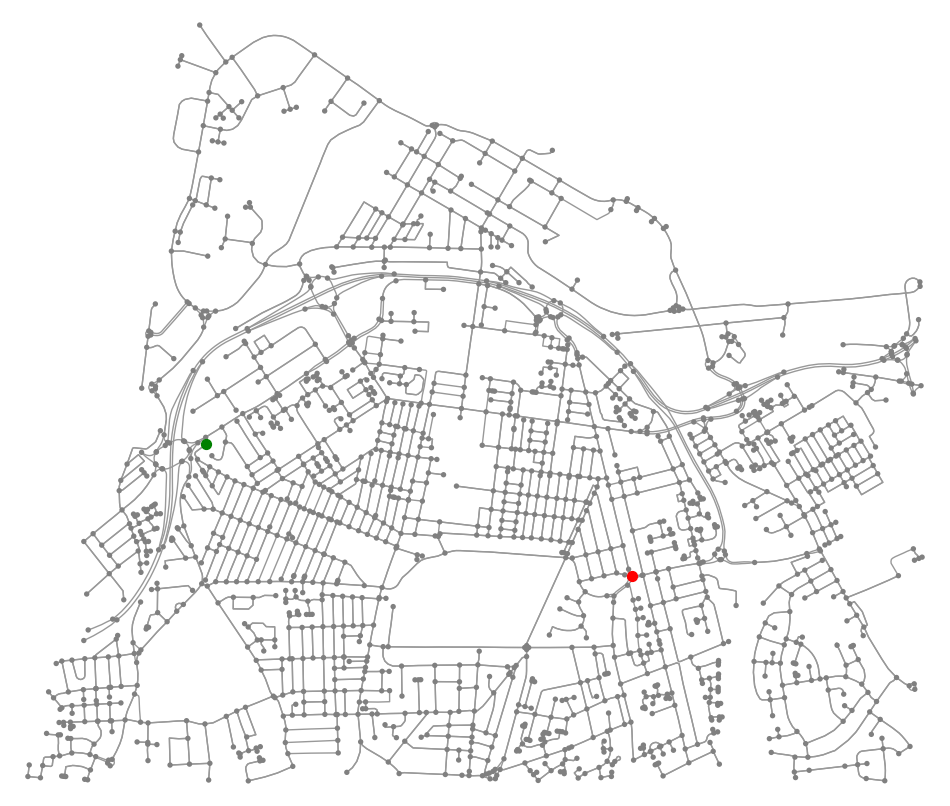

In [9]:
# Displaying the graph model of the location
# Show the start and destination
# The green node represents the start and the red represents the destination

fig, ax = ox.plot_graph(G, show=False, bgcolor='#ffffff', node_color='grey', figsize=(12, 12))
nx.draw_networkx_nodes(G, pos=ox.graph_to_gdfs(G, nodes=True, edges=False).geometry.map(lambda x: (x.x, x.y)), nodelist=[origin[0]], node_color='green', node_size=50, ax=ax)
nx.draw_networkx_nodes(G, pos=ox.graph_to_gdfs(G, nodes=True, edges=False).geometry.map(lambda x: (x.x, x.y)), nodelist=[destination[0]], node_color='red', node_size=50, ax=ax)
plt.show()


# Dijkstra Uninformed Search Algorithm

Dijkstra's algorithm is used to compute the shortest path between nodes in the weighted graph, quickly verifying whether a path exists.
Travel time is used as the weight, as it represents the true cost of traversing a road while driving or using any other means.
The networkx library includes a built-in implementation of Dijkstra's algorithm, so there is no need to redefine it.


In [10]:
# Compute the shortest path between nodes using Dijkstra's uninformed search algorithm, with the weight set as the travel time (in seconds).
route_by_time = nx.shortest_path(G, source=origin[0], target=destination[0], weight='travel_time', method='dijkstra')

# Compute the time of the shortest path in seconds
route_time = fn.compute_weight(G, route_by_time, "travel_time")
print(f'The shortest path time is {route_time:.2f} seconds, which is {(route_time/60):.2f} minutes.')

tt_distance = fn.compute_weight(G, route_by_time, "length")
print(f'The distance for this path is {tt_distance:.2f} meters, which is {tt_distance/1000:.2f} km.')

The shortest path time is 214.37 seconds, which is 3.57 minutes.
The distance for this path is 2571.71 meters, which is 2.57 km.


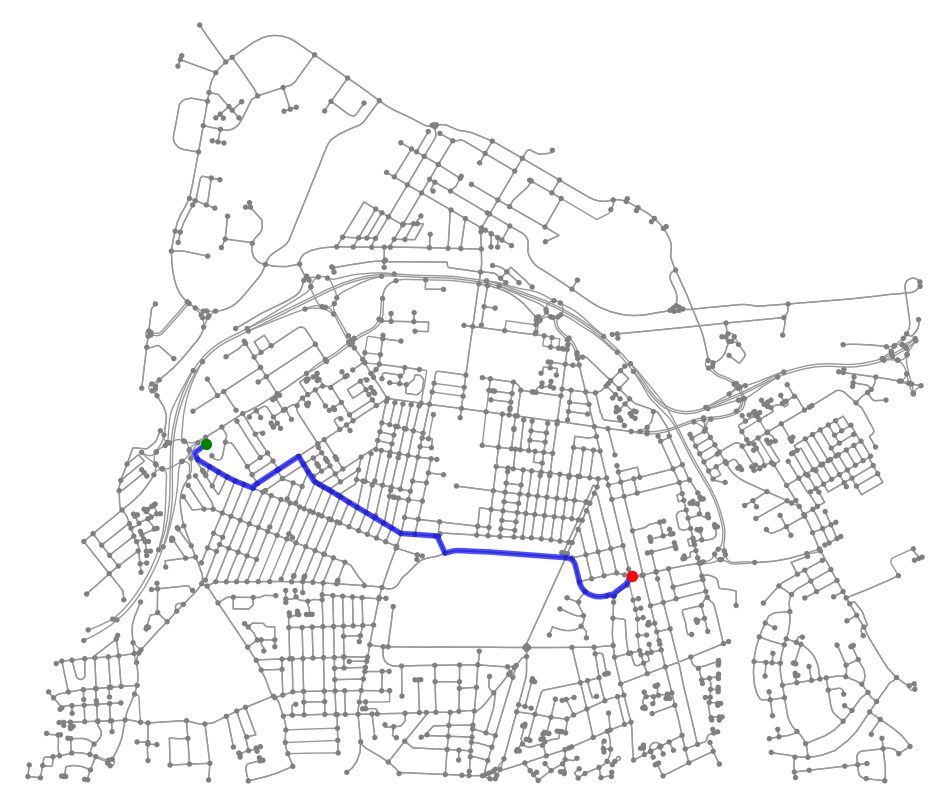

In [11]:
# Plot the network of Dijkstra's shortest path by time
fig, ax = ox.plot_graph(G, show=False, close=False, bgcolor='#ffffff', node_color='grey', figsize=(12, 12))
ox.plot_graph_route(G, route=route_by_time, route_linewidth=4, route_color='blue', route_alpha=0.7, orig_dest_size=50, ax=ax, show=False, close=False)
nx.draw_networkx_nodes(G, pos=ox.graph_to_gdfs(G, nodes=True, edges=False).geometry.map(lambda x: (x.x, x.y)), nodelist=[origin[0]], node_color='green', node_size=50, ax=ax)
nx.draw_networkx_nodes(G, pos=ox.graph_to_gdfs(G, nodes=True, edges=False).geometry.map(lambda x: (x.x, x.y)), nodelist=[destination[0]], node_color='red', node_size=50, ax=ax)
plt.show()

In [12]:
# Get the coordinates of Dijkstra's shortest paths
# rt = route_by_time

coordinates_for_rt = fn.get_coordinates(G, route_by_time)

In [13]:
# display OSM path for the route
fig = fn.plot_maps(coordinates_for_rt, title='Dijkstra search algorithm')
fig.show()

In [14]:
# confirm results of Dijkstra's search algorithm with OSM data

osm_routes = fn.get_osm_map_details(coordinates_for_rt[0], coordinates_for_rt[-1])
osm_direction_coordinates = fn.get_osm_routes(osm_routes)

In [15]:
# Confirm with Open street map data
print(f"The shortest path distance by Open street map is {osm_routes['routes'][0]['distance']} meters, which is {(osm_routes['routes'][0]['distance']/1000):.2f} km")
print(f"The shortest path travel time by Open street map is {osm_routes['routes'][0]['duration']} seconds, which is {osm_routes['routes'][0]['duration']/60:.2f} minutes")
print(f"Assuming an average speed of {(osm_routes['routes'][0]['distance']/osm_routes['routes'][0]['duration']):.2f} m/s or {(osm_routes['routes'][0]['distance']/osm_routes['routes'][0]['duration'])*3.6:.2f} km/s")

The shortest path distance by Open street map is 2577.9 meters, which is 2.58 km
The shortest path travel time by Open street map is 285.4 seconds, which is 4.76 minutes
Assuming an average speed of 9.03 m/s or 32.52 km/s


In [16]:
# display OSM path
# Click on the play button to see the path movement
fig = fn.plot_maps(osm_direction_coordinates, title='OSM shortest path', )
fig.show()


The path generated by Dijkstra is the same as that in OSM.
This confirms that Dijkstra's search algorithm, using travel time as the weight, returns the most optimal path, as it aligns with live OpenStreetMap data.



# Reinforcement Learning

In the previous variant of this work, we proved that reinforcement learning is useful for pathfinding in dynamic environments by comparing the outcomes of different search algorithms and RL approach.
However, this work aims to reduce the computational inefficiencies of using RL alone in a dynamic environment by integrating search into its exploration and exploitation process.
This is further explained in the next two block-level cells by comparing the outcome of a bare RL agent with that of an RL agent enhanced by the Dijkstra search algorithm.



## Create Environment

Gymnasium package is used to create the custom environment.
The environment is based on the graph network model of the location rendered by OSMnx.



### Environment Class


In [17]:
class MiddlesbroughEnv(gym.Env):
    def __init__(self, graph, start_node, goal_node, search=False, traffic=False, closure=False, step_size=1):
        super(MiddlesbroughEnv, self).__init__()

        # set the graph
        self.graph = graph

        # Max number of neighbor for any node, to be used to initialize the agent's Qtable
        self.max_neighbor = self._unique_neighbor_count(self.graph)

        # Step size for moving
        self.step_size = step_size

        # Get nodes and edges
        self.nodes = list(self.graph.nodes)
        self.edges = list(self.graph.edges)

        # Map node IDs to sequential indices (useful for the Qlearning matrix)
        self.node_to_index = {node_id: idx for idx, node_id in enumerate(self.nodes)}
        self.index_to_node = {idx: node_id for idx, node_id in enumerate(self.nodes)}

        # Set the start and goal node
        self.start_node = start_node
        self.goal_node = goal_node

        # set temp start and goal node for agents with search
        self.temp_start_node = self.start_node
        self.temp_goal_node = self.goal_node
            
        # Initialize agent position
        self.current_node = self.start_node

        # Visited nodes
        self.visited_nodes = [self.current_node]
        
        self.traffic = traffic
        self.closure = closure

        # initialize traffic nodes and closure nodes
        self.traffic_nodes = []
        self.closure_nodes = []

        self.search = search

        if self.search:
            self.agent_update = False
        else:
            self.agent_update = True
            
        self.guess_path = nx.shortest_path(G, source=self.start_node, target=self.goal_node, weight='travel_time', method='dijkstra')
        
        ''' # Simulate dynamic road conditions such as closed roads and traffic congestions.
        if self.traffic is True or self.closure is True:
            # if traffic is true or closure is true, guess the shortest path the agent may follow
            # set a traffic node or a road closure node.
            # road closure nodes will be considered dead end, thus there will be no neighbor nodes
            self.guess_path = nx.shortest_path(G, source=self.start_node, target=self.goal_node, weight='travel_time', method='dijkstra')'''

        if self.traffic is True:
            self.traffic_nodes.append(self.guess_path[random.randint(1, len(self.guess_path)-2)])  # avoid start and destination nodes


        if self.closure is True:
            self.closure_nodes.append(self.guess_path[random.randint(1, len(self.guess_path)-2)])  # avoid start and destination nodes


        # Calculate neighbors of the start node
        start_neighbors = self._get_neighbors(self.start_node)

        # Initialize dynamic action space with the size of the start node's neighbors
        self.action_space = spaces.Discrete(len(start_neighbors))

        # Observation space: number of nodes in the graph
        self.observation_space = spaces.Discrete(len(self.nodes))

    def _unique_neighbor_count(self, graph):
        """Get the highest neighbor count"""
        unique_neighbors_count = {node: len(list(graph.neighbors(node))) for node in graph.nodes()}
        max_neighbors_node = max(unique_neighbors_count, key=unique_neighbors_count.get)
        max_neighbors_count = unique_neighbors_count[max_neighbors_node]
        return max_neighbors_count

    def _get_neighbors(self, node):
        """Get all valid neighbors of the current node."""
        valid_neighbors = []
        '''# road closures are treated as dead end, so check if the current node is a closed road
        if self.closure and node in self.closure_nodes:
            return valid_neighbors'''
        neighbors = list(self.graph.neighbors(node))
        for neighbor in neighbors:
            # Make sure the parent node is not included in the neighbors
            if neighbor not in self.visited_nodes:
                valid_neighbors.append(neighbor)
        return valid_neighbors

    def _update_action_space(self):
        """Update the action space based on the number of neighbors."""
        neighbors = self._get_neighbors(self.current_node)
        self.action_space = spaces.Discrete(len(neighbors))  # Dynamic size based on neighbors

    def _map_action_to_neighbor(self, action, neighbors):
        """Map the action to a neighbor node."""
        if action < len(neighbors):
            return neighbors[action]
        return None  # Invalid action

    def update_start_goal(self, p):
        # find the next available node to reconnect
        for i in range(self.guess_path.index(self.current_node)+1, len(self.guess_path)):
            if self.guess_path[i] not in self.traffic_nodes and self.guess_path[i] not in self.closure_nodes:
                # found the next valid node to connect the rest with
                self.goal_node = self.guess_path[i]
                break
        self.agent_update = True

    def step(self, action):
        """Take an action and update the environment."""

        # for each step
        if env.search:
            reward = 0
        else:
            reward = -1

        # Get all neighbors
        neighbors = self._get_neighbors(self.current_node)

        # Map the action to a neighbor
        next_node = self._map_action_to_neighbor(action, neighbors)

        if next_node is None:
            # Invalid action: no neighbor mapped to this action
            reward += -10 # penalty
            done = True
            return np.array(self.node_to_index[self.current_node], dtype=np.int32), reward, done, {'update':self.agent_update}

        # Get previous node
        parent_node = self.current_node

        # Move to the next node
        self.current_node = next_node
        
        # Update visited nodes for visualization
        self.visited_nodes.append(self.current_node)

        # Check if the agent has reached the destination
        done = self.current_node == self.goal_node
        if done:
            if self.search:
                self.start_node = self.temp_start_node
                self.goal_node = self.temp_goal_node
                self.agent_update = False
            if env.search:
                reward += 10
            else:
                reward += 1000 # Big reward for reaching the destination
            return np.array(self.node_to_index[self.current_node], dtype=np.int32), reward, done, {'update':True}

        if self._get_neighbors(self.current_node):
            # Update the action space for the current node
            self._update_action_space()
        else:
            # Dead end, no neighbors
            reward += -10 # penalty
            done = True
            return np.array(self.node_to_index[self.current_node], dtype=np.int32), reward, done, {'update':self.agent_update}

        # check for closure nodes
        if self.closure:
            if self.current_node in self.closure_nodes:
                if self.search:
                    # Update the start and destination nodes
                    self.update_start_goal(parent_node)
                # The road is closed
                reward += -10 # penalty
                done = True
                return np.array(self.node_to_index[self.current_node], dtype=np.int32), reward, done, {'update':self.agent_update}
            
        # Check for traffic
        if self.traffic:
            if self.current_node in self.traffic_nodes:
                if self.search:
                    # Update the start and destination nodes
                    self.update_start_goal(parent_node)
                # Check if alternative routes are available
                alternative_neighbors = [neighbor for neighbor in self._get_neighbors(parent_node) if neighbor not in self.traffic_nodes]
                if alternative_neighbors:
                    # penalty if there are alternative routes
                    reward += -5
                    done = True  # Force agent to try alternative routes
                    return np.array(self.node_to_index[self.current_node], dtype=np.int32), reward, done, {'update':self.agent_update}
                else:
                    # If no alternative, assume waiting for congestion to clear
                    reward += -5

        # Return the state (mapped index), reward, and done status
        return np.array(self.node_to_index[self.current_node], dtype=np.int32), reward, done, {'update':self.agent_update}

    def reset(self):
        """Reset the environment."""
        self.current_node = self.start_node
        self.visited_nodes = [self.current_node]
        self._update_action_space()
        return np.array(self.node_to_index[self.current_node], dtype=np.int32)

    def render(self, mode='human'):
        """Render the current position."""
        print(f"Current Node: {self.current_node}, Latitude: {self.graph.nodes[self.current_node]['y']}, Longitude: {self.graph.nodes[self.current_node]['x']}")
        print(f"Visited Nodes: {self.visited_nodes}")



### Environment information

The environment is a graph model of a road network in a real-world location, with each coordinate point on the road represented as a node, while the edges contain additional information.
It is designed so that once a node is visited, it cannot be revisited; in essence, a node cannot return to its parent node.
We know that RL can find the optimal path. The goal is to reduce the computational resources it consumes in doing so by minimizing the number of episodes required for the RL agent to converge.

The reward is designed as follows
- +1000 points for reaching its destination
- -1 for each time step
- -10 for reaching a dead end, that is a node without any other nodes except its parent node or for road closure nodes
- -10 for an illegal action that does not map to node, there by making the next node none
- -5 for traffic congestion

The environment has a dynamic action space, meaning the actions change depending on each node(state) visited.
This is because different nodes (states) have a different number of direct neighbors.
This design keeps the actions within the scope of the neighbors of the current node (state) to avoid choosing an action that is out of bound.

In [18]:
# Initialize the environment
env = MiddlesbroughEnv(G, origin[0], destination[0])

# render the environment
env.render()

Current Node: 7654939, Latitude: 54.5713396, Longitude: -1.2539409
Visited Nodes: [7654939]


In [19]:
# View the action space for the origin node
print(f'Action space {env.action_space}')

Action space Discrete(1)


In [20]:
# we confirm that by checking the direct neighbors of the current node
print(list(G.neighbors(env.current_node)))

[1110371602]


In [21]:
# View the observation space - in this case, the observation or states are the different nodes
print(f'Observation space {env.observation_space}')

Observation space Discrete(1788)



## Create the Agent

Using Q-learning RL Algorithm to create an agent for the environment.



### Agent Class


In [530]:
class QLearningAgent:
    def __init__(self, environment, learning_rate=0.1, discount_factor=0.9, epsilon=0.1):
        self.env = environment
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.temp_epsilon = self.epsilon
        if self.env.search:
            self.epsilon = -self.temp_epsilon
        self.list_all_rewards = []
        # learning_rate=0.1, discount_factor=0.9, epsilon=1, min_epsilon=0.1, decay_rate=0.995
        # self.min_epsilon = min_epsilon
        # self.decay_rate = decay_rate

        # Initialize Q-table with zeros (number of states * max number of actions, which is the max neighbor overall)
        self.q_table = np.zeros((self.env.observation_space.n, self.env.max_neighbor))

        if self.env.search:
            # If search is true, then integrate Dijkstra search algorithm
            #self.search_path = nx.shortest_path(self.env.graph, source=self.env.start_node, target=self.env.goal_node, weight='travel_time', method='dijkstra')
            for i in range(len(self.env.guess_path)):
                # normal reward for each time step
                reward = 10
                done = False

                if self.env.guess_path[i+1] == self.env.guess_path[-1]:
                    # the goal node with the max reward
                    reward += 100
                    done = True

                state = self.env.node_to_index[self.env.guess_path[i]]
                
                # get the parent node so as to avoid it
                prev = None
                if i != 0:
                    prev = self.env.guess_path[i-1]
                    
                action = self.get_action(self.env.guess_path[i], self.env.guess_path[i+1], prev)
                next_state = self.env.node_to_index[self.env.guess_path[i+1]]

                self.update_q_table(state, action, reward, next_state, done)

                if done:
                    break

    def get_action(self, current, next, prev):
        valid = []
        neighbors = list(self.env.graph.neighbors(current))
        if prev:
            for neighbor in neighbors:
                if neighbor != prev:
                    valid.append(neighbor)
            action = valid.index(next)
        else:
            action = neighbors.index(next)
            
        return action

    def choose_action(self, state):
        """Choose action using epsilon-greedy policy."""
        if random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()  # Explore: random action
        else:
            n = self.env.action_space.n  # make sure we don't go out of bound
            return np.argmax(self.q_table[state][:n])  # Exploit: best action based on Q-table

    def update_q_table(self, state, action, reward, next_state, done):
        """Update Q-table using the Q-learning formula."""
        old_q_value = self.q_table[state, action]
        future_q_value = np.max(self.q_table[next_state])
        self.q_table[state, action] = (1 - self.learning_rate) * old_q_value + self.learning_rate * (reward + self.discount_factor * future_q_value)

    def train(self, num_episodes=100000, display=False):
        """Train the agent using Q-learning."""
        total_episode_reward = 0
        highest_reward = 0
        time_steps = 0
        self.list_all_rewards = []
        for episode in range(num_episodes):
            state = self.env.reset()
            done = False
            total_reward = 0
            while not done:
                action = self.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)
                if self.env.search:
                    if _['update']:
                        self.update_q_table(state, action, reward, next_state, done)
                        self.epsilon = self.temp_epsilon
                    else:
                        self.epsilon = -self.temp_epsilon
                else:
                    self.update_q_table(state, action, reward, next_state, done)
                    
                state = next_state
                total_reward += reward

                time_steps += 1

            # Decay exploration rate
            # self.epsilon = max(self.min_epsilon, self.epsilon * self.decay_rate)

            if display:
                if episode % 100 == 0:
                    clear_output(wait=True)
                    print(f"Episode {episode}, Total Reward: {total_reward}.")

            total_episode_reward += total_reward

            self.list_all_rewards.append(total_episode_reward)
            
            # compute the highest reward for the episodes
            if total_reward > highest_reward:
                highest_reward = total_reward

        print(f'Training complete for {num_episodes} steps with the highest reward of {highest_reward} and average reward of {total_episode_reward/num_episodes} and average timestep of {time_steps/num_episodes}.')


    def test(self, num_episodes=100, params=False):
        """Test the agent's performance"""
        penalties = 0
        total_episode_reward = 0
        time_steps = 0
        for episode in range(num_episodes):
            state = self.env.reset()
            done = False
            total_reward = 0
            while not done:
                n = self.env.action_space.n
                # The agent does not explore but exploits learned information from the qtable
                action = np.argmax(self.q_table[state][:n])
                state, reward, done, _ = self.env.step(action)
                total_reward += reward

                # penalty for traffic(-5), dead ends and road closures(-10) and invalid actions(-10)
                # remember the -1 for each step
                if reward in [-6, -11]:
                    penalties += 1

                time_steps += 1

            total_episode_reward += total_reward

        if params:
            return time_steps
        else:
            return penalties, total_episode_reward, time_steps, num_episodes


# Reinforcement Learning (Without Search)

First, we see the performance of the RL agent alone and then compare it with the performance when integrated with search.



## Normal Road Condition

Assuming no road issues, we check to see how the RL agent performs

In [772]:
# Initialize the environment
env = MiddlesbroughEnv(G, origin[0], destination[0])

# render the environment
env.render()

Current Node: 7654939, Latitude: 54.5713396, Longitude: -1.2539409
Visited Nodes: [7654939]


In [773]:
NRLWS_agent = QLearningAgent(env)


### Train Agent


In [774]:
# Train the agent for 100000 episodes for the best result
NRLWS_agent.train(num_episodes=30000, display=True)

Episode 29900, Total Reward: -28.
Training complete for 30000 steps with the highest reward of 969 and average reward of 239.17 and average timestep of 27.637333333333334.



### Evaluate Agent


In [775]:
# Show the q values for the initial state
NRLWS_agent.q_table[NRLWS_agent.env.node_to_index[NRLWS_agent.env.start_node]]

array([31.68966413,  0.        ,  0.        ,  0.        ])

In [776]:
#Test the agent's performance. No more exploration, only exploitation
NRLWS_penalties, NRLWS_total_reward, NRLWS_timesteps, NRLWS_epoch = NRLWS_agent.test(num_episodes=1)

# render the custom environment
NRLWS_agent.env.render()

Current Node: 7632848, Latitude: 54.5657917, Longitude: -1.2230372
Visited Nodes: [7654939, 1110371602, 27698842, 1243218197, 27728062, 694082453, 600748426, 600748424, 7639034, 302022839, 302022838, 694082427, 694082439, 694082443, 694082445, 694082444, 814809026, 815505173, 815505181, 292261801, 600748406, 695109668, 2061046713, 7632809, 7632811, 724104513, 6305621435, 8313376220, 7632821, 4545222887, 569940163, 7632848]


In [777]:
# Compute the results
print(f'Agent results after {NRLWS_epoch} episodes')
print(f'Average time steps per episode {NRLWS_timesteps/NRLWS_epoch}')
print(f'Average penalties per episode {NRLWS_penalties/NRLWS_epoch}')
print(f'Agent rewards per episode {NRLWS_total_reward/NRLWS_epoch}')

Agent results after 1 episodes
Average time steps per episode 31.0
Average penalties per episode 0.0
Agent rewards per episode 969.0


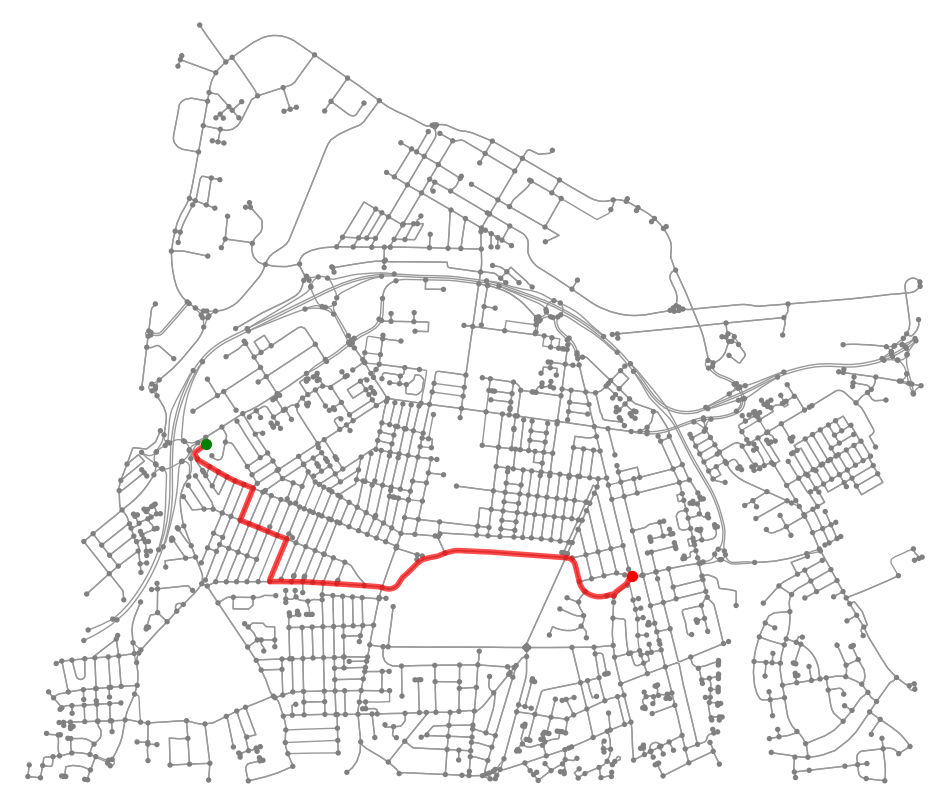

In [778]:
# Plot the agents best learned route
fig, ax = ox.plot_graph(G, show=False, close=False, bgcolor='#ffffff', node_color='grey', figsize=(12, 12))
ox.plot_graph_route(G, route=NRLWS_agent.env.visited_nodes, route_linewidth=4, route_color='red', route_alpha=0.7, orig_dest_size=50, ax=ax, show=False, close=False)
nx.draw_networkx_nodes(G, pos=ox.graph_to_gdfs(G, nodes=True, edges=False).geometry.map(lambda x: (x.x, x.y)), nodelist=[origin[0]], node_color='green', node_size=50, ax=ax)
nx.draw_networkx_nodes(G, pos=ox.graph_to_gdfs(G, nodes=True, edges=False).geometry.map(lambda x: (x.x, x.y)), nodelist=[destination[0]], node_color='red', node_size=50, ax=ax)
plt.show()

In [779]:
NRLWS_agent_visited_nodes = NRLWS_agent.env.visited_nodes
NRLWS_agent_sim_distance = fn.compute_weight(G, NRLWS_agent_visited_nodes, 'length')
NRLWS_agent_sim_time = fn.compute_weight(G, NRLWS_agent_visited_nodes, 'travel_time')
print(f'The distance for the RL agent (without search) under normal road conditions {NRLWS_agent_sim_distance:.2f} meters, which is {NRLWS_agent_sim_distance/1000:.2f} km')
print(f'The travel time for the RL agent (without search) under normal road conditions {NRLWS_agent_sim_time:.2f} seconds, which is {NRLWS_agent_sim_time/60:.2f} minutes')

The distance for the RL agent (without search) under normal road conditions 2933.71 meters, which is 2.93 km
The travel time for the RL agent (without search) under normal road conditions 256.75 seconds, which is 4.28 minutes


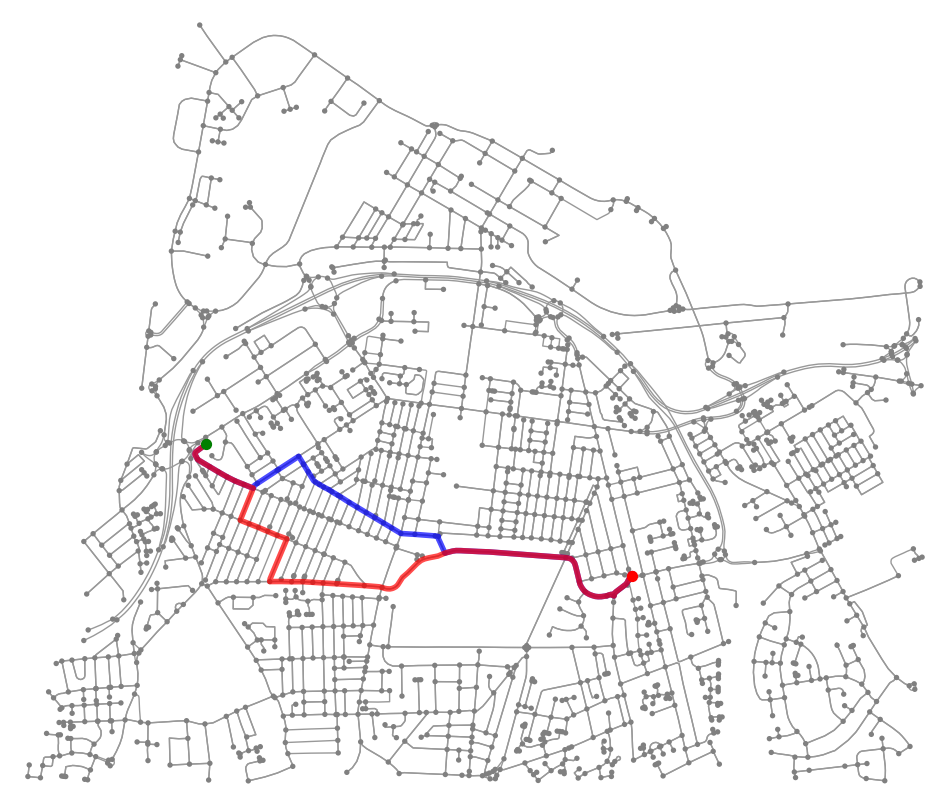

In [780]:
# View both routes of RL agent and Dijstra on the same map network
# Blue for Dijkstra's shortest route by travel time and red for RL agent
fig, ax = ox.plot_graph(G, show=False, close=False, bgcolor='#ffffff', node_color='grey', figsize=(12, 12))
ox.plot_graph_route(G, route=route_by_time, route_linewidth=4, route_color='blue', route_alpha=0.7, orig_dest_size=50, ax=ax, show=False, close=False)
ox.plot_graph_route(G, route=NRLWS_agent.env.visited_nodes, route_linewidth=4, route_color='red', route_alpha=0.7, orig_dest_size=50, ax=ax, show=False, close=False)
nx.draw_networkx_nodes(G, pos=ox.graph_to_gdfs(G, nodes=True, edges=False).geometry.map(lambda x: (x.x, x.y)), nodelist=[origin[0]], node_color='green', node_size=50, ax=ax)
nx.draw_networkx_nodes(G, pos=ox.graph_to_gdfs(G, nodes=True, edges=False).geometry.map(lambda x: (x.x, x.y)), nodelist=[destination[0]], node_color='red', node_size=50, ax=ax)
plt.show()


## Dynamic Road Conditions 

Simulation of dynamic road conditions in real world scenarios such as traffic congestions and closed roads etc.

The agent can adapt in real time to real-world scenarios, such as traffic congestion and road blockades, to dynamically reroute and continue toward the goal if there are other paths.


In [813]:
# Initialize a new environment
env = MiddlesbroughEnv(G, origin[0], destination[0], traffic=True, closure=True)
env.traffic_nodes = [7639034]
env.closure_nodes = [724104513]

# render the environment
env.render()

Current Node: 7654939, Latitude: 54.5713396, Longitude: -1.2539409
Visited Nodes: [7654939]


Closed road: [724104513]
Traffic congestion: [7639034]


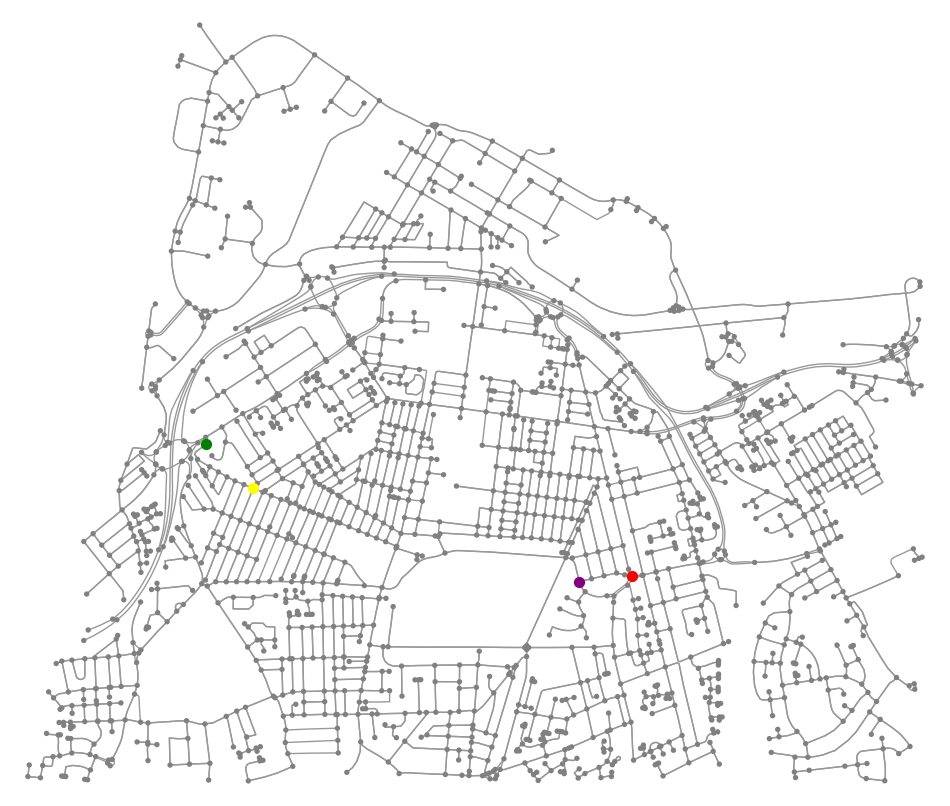

In [814]:
if env.traffic is True or env.closure is True:
    # Purple dot represent closed roads
    # Yellow dot represent traffic congestion
    # Green and Red dots are origin and destination respectively
    print(f'Closed road: {env.closure_nodes}')
    print(f'Traffic congestion: {env.traffic_nodes}')
    fn.show_plots(G, t=env.traffic_nodes, c=env.closure_nodes, o=[origin[0]], d=[destination[0]])

In [815]:
DRLWS_agent = QLearningAgent(env)


### Train Agent


In [816]:
DRLWS_agent.train(num_episodes=50000, display=True)

Episode 49900, Total Reward: 965.
Training complete for 50000 steps with the highest reward of 967 and average reward of 254.95208 and average timestep of 27.94452.



### Evaluate Agent


In [817]:
#Test the agent's performance. No more exploration, only exploitation
DRLWS_penalties, DRLWS_total_reward, DRLWS_timesteps, DRLWS_epoch = DRLWS_agent.test(num_episodes=1)

# render the custom environment
DRLWS_agent.env.render()

Current Node: 7632848, Latitude: 54.5657917, Longitude: -1.2230372
Visited Nodes: [7654939, 1110371602, 27698842, 1243218197, 27728062, 694082453, 600748426, 600748424, 571399400, 302022839, 302022838, 694082427, 694082439, 694082443, 694082445, 694082444, 814809026, 815505173, 815505181, 292261801, 600748406, 695109668, 2061046713, 7632809, 7632811, 7634256, 7634257, 724104488, 724104475, 623083802, 724104595, 623083730, 10985244604, 7632848]


In [818]:
# Compute the results
print(f'Agent results after {DRLWS_epoch} episodes')
print(f'Average time steps per episode {DRLWS_timesteps/DRLWS_epoch}')
print(f'Average penalties per episode {DRLWS_penalties/DRLWS_epoch}')
print(f'Agent rewards per episode {DRLWS_total_reward/DRLWS_epoch}')

Agent results after 1 episodes
Average time steps per episode 33.0
Average penalties per episode 0.0
Agent rewards per episode 967.0


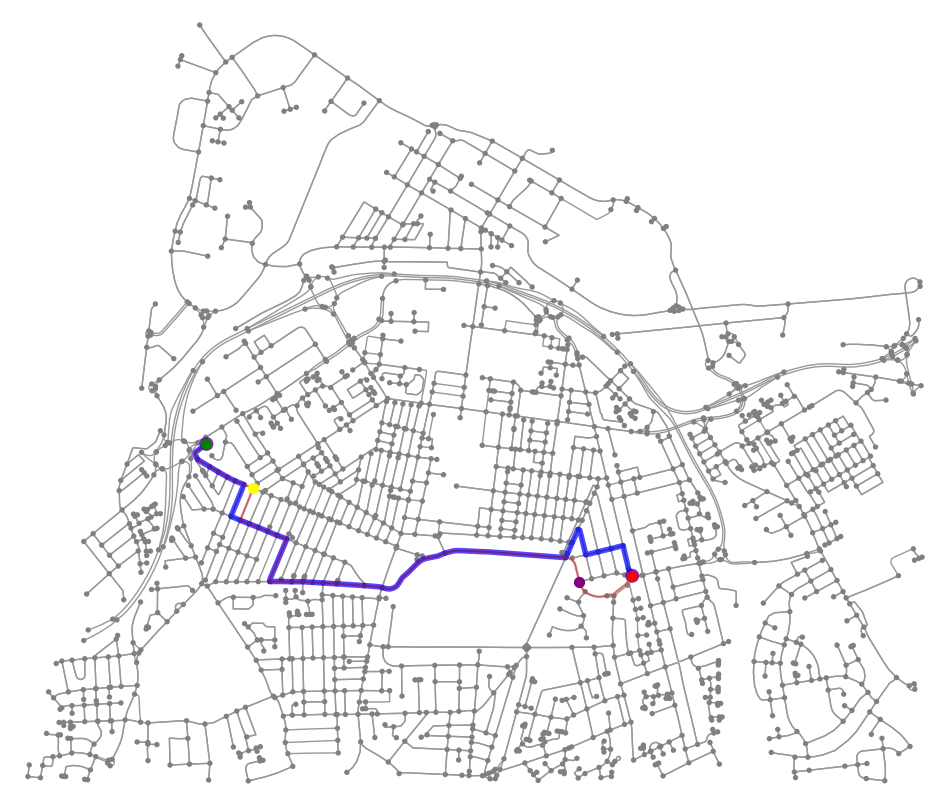

In [819]:
# Plot the agents best learned route and show the traffic and closed roads
fn.show_plots(G, r=DRLWS_agent.env.visited_nodes, t=DRLWS_agent.env.traffic_nodes, c=DRLWS_agent.env.closure_nodes, o=[origin[0]], d=[destination[0]], default=NRLWS_agent_visited_nodes)

The image above shows that the RL agent (without search) can learn an alternative route to bypass dynamic road conditions such as traffic congestion and road closures.

However, it takes much longer for the RL agent to start reaching the goal. This will be mitigated in the next phase when search is integrated to minimize the training episodes. closed.

In [820]:
DRLWS_agent_visited_nodes = DRLWS_agent.env.visited_nodes
DRLWS_agent_sim_distance = fn.compute_weight(G, DRLWS_agent_visited_nodes, 'length')
DRLWS_agent_sim_time = fn.compute_weight(G, DRLWS_agent_visited_nodes, 'travel_time')
print(f'The distance for the RL agent(without search) under dynamic road conditions (traffic and road closure simulation) is {DRLWS_agent_sim_distance:.2f} meters, which is {DRLWS_agent_sim_distance/1000:.2f} km')
print(f'The travel time for the RL agent(without search) under dynamic road conditions (traffic and road closure simulation) is {DRLWS_agent_sim_time:.2f} seconds, which is {DRLWS_agent_sim_time/60:.2f} minutes')

The distance for the RL agent(without search) under dynamic road conditions (traffic and road closure simulation) is 3058.20 meters, which is 3.06 km
The travel time for the RL agent(without search) under dynamic road conditions (traffic and road closure simulation) is 276.98 seconds, which is 4.62 minutes



# Merging Search and Reinforcement Learning

Here, search is integrated with the RL agent to reduce the number of episodes required for convergence, thereby reducing computational inefficiencies.


## Normal Road Condition

Assuming no road issues, we check to see how the RL agent performs


In [752]:
# Initialize a new environment
env = MiddlesbroughEnv(G, origin[0], destination[0], search=True)

# render the environment
env.render()

Current Node: 7654939, Latitude: 54.5713396, Longitude: -1.2539409
Visited Nodes: [7654939]


In [753]:
NRLS_agent = QLearningAgent(env)


### Train Agent


In [754]:
NRLS_agent.train(num_episodes=1, display=True)

Episode 0, Total Reward: 10.
Training complete for 1 steps with the highest reward of 10 and average reward of 10.0 and average timestep of 41.0.


Under normal road conditions, we don't need to train the agent, as the search has already learned the path for the agent to follow, so no additional training is required.


### Evaluate Agent


In [755]:
# Show the q values for the initial state
NRLS_agent.q_table[NRLS_agent.env.node_to_index[NRLS_agent.env.start_node]]

array([1., 0., 0., 0.])

In [756]:
# Path generated by search
print(NRLS_agent.env.guess_path)

[7654939, 1110371602, 27698842, 1243218197, 27728062, 694082453, 600748426, 600748424, 7639034, 7654955, 27748787, 7639050, 7639049, 1143766028, 7639048, 600748438, 7639047, 695111881, 7639046, 1143758860, 7639045, 7639043, 1143758843, 7639042, 7639040, 7639039, 7639038, 7639037, 7639036, 7630514, 7634278, 1698348465, 7634292, 7632809, 7632811, 724104513, 6305621435, 8313376220, 7632821, 4545222887, 569940163, 7632848]


In [757]:
#Test the agent's performance. No more exploration, only exploitation
NRLS_agent_penalties, NRLS_agent_total_reward, NRLS_agent_timesteps, NRLS_agent_epoch = NRLS_agent.test(num_episodes=1)

# render the custom environment
NRLS_agent.env.render()

Current Node: 7632848, Latitude: 54.5657917, Longitude: -1.2230372
Visited Nodes: [7654939, 1110371602, 27698842, 1243218197, 27728062, 694082453, 600748426, 600748424, 7639034, 7654955, 27748787, 7639050, 7639049, 1143766028, 7639048, 600748438, 7639047, 695111881, 7639046, 1143758860, 7639045, 7639043, 1143758843, 7639042, 7639040, 7639039, 7639038, 7639037, 7639036, 7630514, 7634278, 1698348465, 7634292, 7632809, 7632811, 724104513, 6305621435, 8313376220, 7632821, 4545222887, 569940163, 7632848]


In [758]:
# Compute the results
print(f'Agent results after {NRLS_agent_epoch} episodes')
print(f'Average time steps per episode {NRLS_agent_timesteps/NRLS_agent_epoch}')
print(f'Average penalties per episode {NRLS_agent_penalties/NRLS_agent_epoch}')
print(f'Agent rewards per episode {NRLS_agent_total_reward/NRLS_agent_epoch}')

Agent results after 1 episodes
Average time steps per episode 41.0
Average penalties per episode 0.0
Agent rewards per episode 10.0


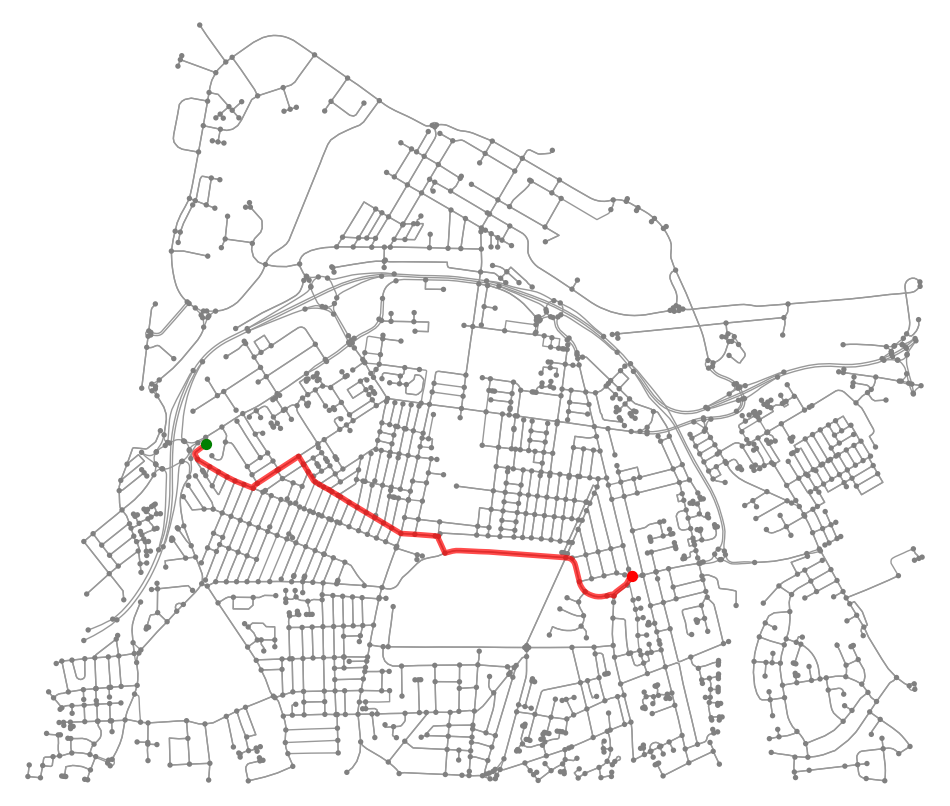

In [759]:
# Plot the agents best learned route
fig, ax = ox.plot_graph(G, show=False, close=False, bgcolor='#ffffff', node_color='grey', figsize=(12, 12))
ox.plot_graph_route(G, route=NRLS_agent.env.visited_nodes, route_linewidth=4, route_color='red', route_alpha=0.7, orig_dest_size=50, ax=ax, show=False, close=False)
nx.draw_networkx_nodes(G, pos=ox.graph_to_gdfs(G, nodes=True, edges=False).geometry.map(lambda x: (x.x, x.y)), nodelist=[origin[0]], node_color='green', node_size=50, ax=ax)
nx.draw_networkx_nodes(G, pos=ox.graph_to_gdfs(G, nodes=True, edges=False).geometry.map(lambda x: (x.x, x.y)), nodelist=[destination[0]], node_color='red', node_size=50, ax=ax)
plt.show()

In [760]:
NRLS_agent_visited_nodes = NRLS_agent.env.visited_nodes
NRLS_agent_distance = fn.compute_weight(G, NRLS_agent_visited_nodes, 'length')
NRLS_agent_time = fn.compute_weight(G, NRLS_agent_visited_nodes, 'travel_time')
print(f'The distance for RL agent (with search for initial path planning) under normal road conditions is {NRLS_agent_distance:.2f} meters, which is {(NRLS_agent_distance/1000):.2f} km')
print(f'The travel time for RL agent (with search for initial path planning) under normal road conditions is {NRLS_agent_time:.2f} seconds, which is {(NRLS_agent_time/60):.2f} minutes')

The distance for RL agent (with search for initial path planning) under normal road conditions is 2571.71 meters, which is 2.57 km
The travel time for RL agent (with search for initial path planning) under normal road conditions is 214.37 seconds, which is 3.57 minutes



## Dynamic Road Conditions

Simulation of dynamic road conditions in real world scenarios such as traffic congestions and closed roads etc.

The agent can adapt in real time to real-world scenarios, such as traffic congestion and road blockades, to dynamically reroute and continue toward the goal if there are other paths. There are no free sources for real-time traffic information, and even if there were, making API calls would be too computationally expensive, given that the reinforcement learning agent is trained for a large number of episodes. However, a mechanism is used to simulate this by randomly selecting nodes to represent traffic or road closure issues.


In [761]:
# Initialize a new environment
env = MiddlesbroughEnv(G, origin[0], destination[0], search=True, traffic=True, closure=True)
env.closure_nodes = [7639050]
env.traffic_nodes = [7639040]
# render the environment
env.render()

Current Node: 7654939, Latitude: 54.5713396, Longitude: -1.2539409
Visited Nodes: [7654939]


Closed road: [7639050]
Traffic congestion: [7639040]


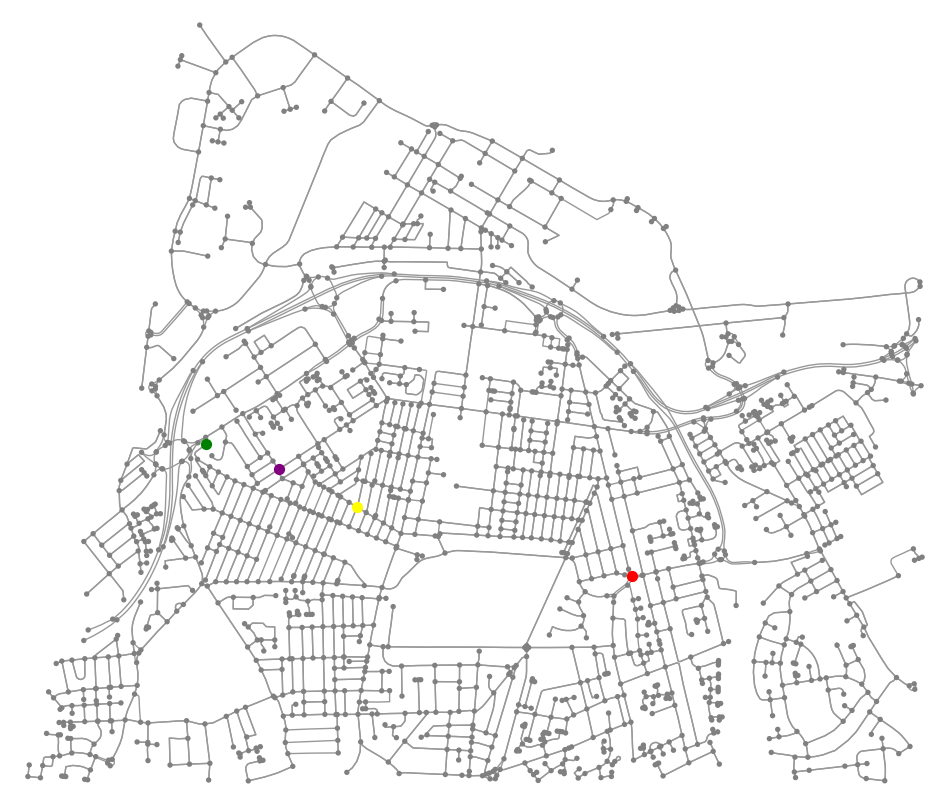

In [762]:
if env.traffic is True or env.closure is True:
    # Purple dot represent closed roads
    # Yellow dot represent traffic congestion
    # Green and Red dots are origin and destination respectively
    print(f'Closed road: {env.closure_nodes}')
    print(f'Traffic congestion: {env.traffic_nodes}')
    fn.show_plots(G, t=env.traffic_nodes, c=env.closure_nodes, o=[origin[0]], d=[destination[0]])

In [763]:
DRLS_agent = QLearningAgent(env)


### Train Agent


In [764]:
DRLS_agent.train(num_episodes=100, display=True)

Episode 0, Total Reward: -10.
Training complete for 100 steps with the highest reward of 10 and average reward of 2.85 and average timestep of 35.37.



### Evaluate Agent


In [765]:
# Show the q values for the initial state
DRLS_agent.q_table[DRLS_agent.env.node_to_index[DRLS_agent.env.start_node]]

array([0.71595794, 0.        , 0.        , 0.        ])

In [766]:
# list(env.graph.neighbors(7639048))

In [767]:
#Test the agent's performance. No more exploration, only exploitation
DRLS_agent_penalties, DRLS_agent_total_reward, DRLS_agent_timesteps, DRLS_agent_epoch = DRLS_agent.test(num_episodes=1)

# render the custom environment
DRLS_agent.env.render()

Current Node: 7632848, Latitude: 54.5657917, Longitude: -1.2230372
Visited Nodes: [7654939, 1110371602, 27698842, 1243218197, 27728062, 694082453, 600748426, 600748424, 7639034, 7654955, 27748787, 7639051, 7639048, 600748438, 7639047, 695111881, 7639046, 1143758860, 7639045, 7639043, 1143758843, 7639042, 7639027, 7639026, 7639025, 7639023, 7639038, 7639037, 7639036, 7630514, 7634278, 1698348465, 7634292, 7632809, 7632811, 724104513, 6305621435, 8313376220, 7632821, 4545222887, 569940163, 7632848]


In [768]:
# Compute the results
print(f'Agent results after {DRLS_agent_epoch} episodes')
print(f'Average time steps per episode {DRLS_agent_timesteps/DRLS_agent_epoch}')
print(f'Average penalties per episode {DRLS_agent_penalties/DRLS_agent_epoch}')
print(f'Agent rewards per episode {DRLS_agent_total_reward/DRLS_agent_epoch}')

Agent results after 1 episodes
Average time steps per episode 41.0
Average penalties per episode 0.0
Agent rewards per episode 10.0


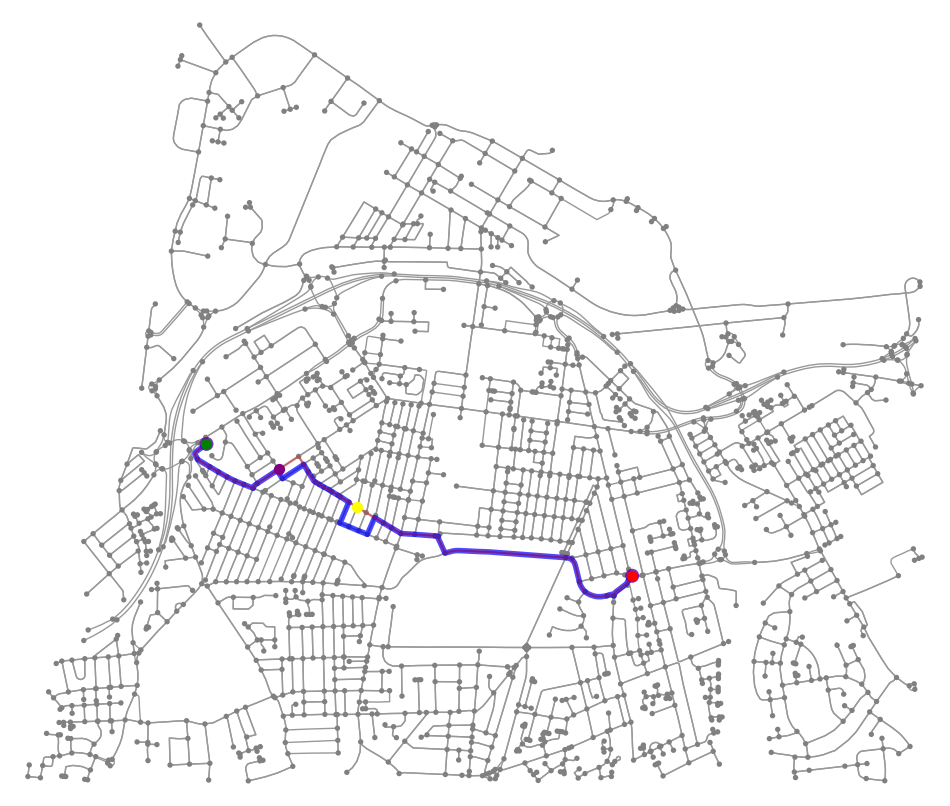

In [769]:
# Plot the agents best learned route and show the traffic and closed roads
fn.show_plots(G, r=DRLS_agent.env.visited_nodes, t=DRLS_agent.env.traffic_nodes, c=DRLS_agent.env.closure_nodes, o=[origin[0]], d=[destination[0]], default=NRLS_agent_visited_nodes)

When search is integrated into RL, the agent primarily exploits known paths. However, whenever a dynamic road issue arises, exploration is triggered. 

The agent finds an alternative route to bypass the road issue and then reconnects with the preplanned path.

In the image above, the purple node represents a closed road. The primary objective of this work is to reduce the computational resources required when using RL alone in a dynamic environment. 

Dijkstra search algorithm initially plans the path, and RL leverages this information while accounting for real-time road conditions. 

This approach minimizes unnecessary exploration, ensuring that the agent explores only when it encounters a dynamic issue. 

As a result, the number of training episodes is significantly reduced to just 1,000, regardless of how many episodes a standalone RL agent would require without search integration.

In [770]:
DRLS_agent_visited_nodes = DRLS_agent.env.visited_nodes
DRLS_agent_distance = fn.compute_weight(G, DRLS_agent_visited_nodes, 'length')
DRLS_agent_time = fn.compute_weight(G, DRLS_agent_visited_nodes, 'travel_time')
print(f'The distance for RL agent (with search for initial path planning) under dynamic road conditions is {DRLS_agent_distance:.2f} meters, which is {(DRLS_agent_distance/1000):.2f} km')
print(f'The travel time for RL agent (with search for initial path planning) under dynamic road conditions is {DRLS_agent_time:.2f} seconds, which is {(DRLS_agent_time/60):.2f} minutes')

The distance for RL agent (with search for initial path planning) under dynamic road conditions is 2762.47 meters, which is 2.76 km
The travel time for RL agent (with search for initial path planning) under dynamic road conditions is 235.51 seconds, which is 3.93 minutes



# Evaluate Result


Text(0, 0.5, 'Rewards')

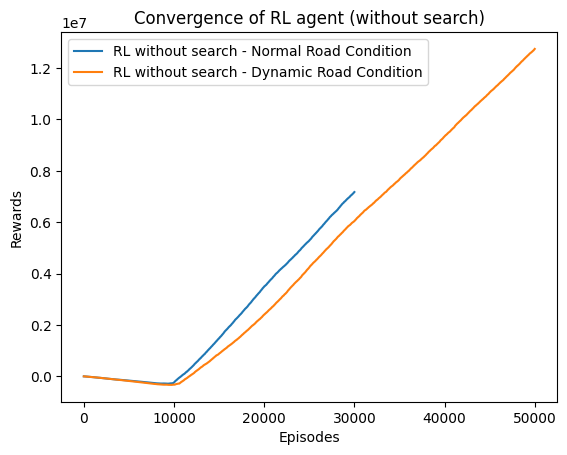

In [823]:
plt.title('Convergence of RL agent (without search)')
sns.lineplot(data=NRLWS_agent.list_all_rewards, label='RL without search - Normal Road Condition')
sns.lineplot(data=DRLWS_agent.list_all_rewards, label='RL without search - Dynamic Road Condition')
plt.xlabel('Episodes')
plt.ylabel('Rewards')

Text(0, 0.5, 'Rewards')

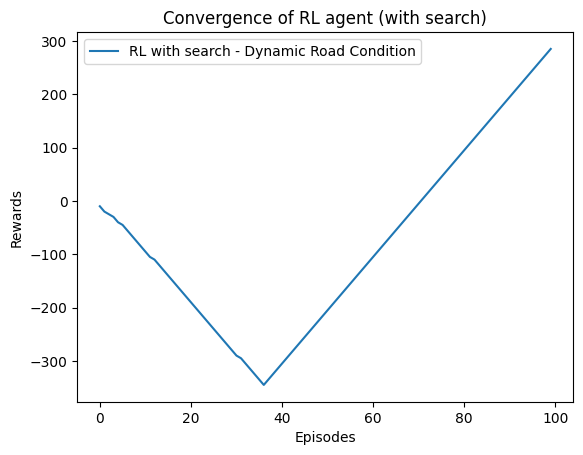

In [825]:
plt.title('Convergence of RL agent (with search)')
sns.lineplot(data=DRLS_agent.list_all_rewards, label='RL with search - Dynamic Road Condition')
plt.xlabel('Episodes')
plt.ylabel('Rewards')


# Summary


With reward shaping and an innovative technique that balances exploration and exploitation, we have successfully integrated search with reinforcement learning to speed up the pathfinding process and reduce the number of episodes required in dynamic environments. 

With search, the RL agent only explores when necessary, specifically, when it encounters road issues. In such cases, it attempts to bypass the block and reconnect with the rest of the already planned path.

In our experiments, a standalone RL agent required about 50,000 episodes to find a path in a dynamic road condition. In contrast, the RL agent enhanced with search was able to reroute and bypass road issues in just 100 episodes. 

While search is significantly faster and produces the shortest paths in static environments, it lacks the adaptability to handle dynamic changes. Conversely, RL is slower and may not always find the optimal path but excels in adapting to dynamic conditions.

By integrating both approaches, we effectively balance their trade-offs, leveraging the efficiency of search and the adaptability of RL. 

This hybrid method shows clear promise and can be especially suitable for real-time navigation systems, autonomous driving, disaster response routing, or any domain requiring efficient, adaptive path planning in uncertain environments.